In [1]:
import numpy as np
import pandas as pd
import mglearn
import sklearn
import matplotlib.pyplot as plt


# Automatic Feature Selection

- increasing the feature dimensionality makes all models more complex, and therefore increases the chance of overfitting.
- to help generalize results, when dealing with high-dimensional datasets in general it can be a good idea to reduce the number of features to only the most useful ones, and discard the rest.
- three basic strategies (for supervised learning) of identifying good features:
1. univariate statistics
2. model-based selection
3. iterative selection


## Univariate Statistics
- we compute whether there is a statistically significant relationship between each feature and the target
- the features that are related with the highest confidence are selected
- with classification, this is known as ANOVA (*analysis of variance*)
- important property of these test is that they are *univariate*, meaning that they only consider each feature individually
    - it is important to acknowledge that a feature will be discarded if it is only informative when combined with another feature
- univariate tests are often very fast to compute and don't require building a model
- the tests are completely independent of the model that will use them

- Scikit-learn univariate feature selection tests include
1. *f_classif* for classification
2. *f_regression* for regression
- there includes a method to discard features based on the *p*-values determined in the test
    - all the methods here to discard features use a threshold to discard all features with too high a *p*-value
- simplest method on how to compute this threshold is *SelectKBest*, which select a fixed number *k*  of the features
- *SelectPercentile*, selects a fixed percentage of features

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# add noise to features to the data
# the first 30 features are from the datasetm the next 50 are noise

X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

#transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample index')

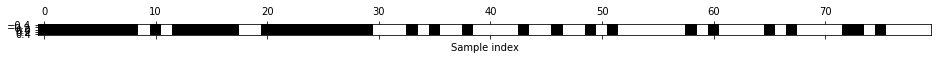

In [5]:
# look at the features that have been selected
mask = select.get_support()
print(mask)

# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("Sample index")

- most of the noise features were removed, but not all of them
- while we kept most of the original features, but some were less informative


In [8]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)
))

Score with all features: 0.930
Score with only selected features: 0.940


## Model-Based Feature Selection
- uses supervised learning to judge the importance of each feature and keeps only the most important ones
- the feature selection model needs to provide some measure of importance for each feature so that they can be ranked by this measure
- decision trees and decision tree-based models provide a *feature_importances_* attribute which directly encodes the importance of each feature
- linear models have coefficients, which can also be used to capture feature importances by considering the absolute values
- L1 penalty learn sparse coefficients, only using a small subset of features (which can be a form of feature selection itself) and can be used in preprocessing step
- in contrast to univariate selection, model-based selection considers all features at once, and so can capture interactions (if the model can capture them)
- Scikit-learn provides a transformer, *SelectFromModel*, to use model-based feature selection


In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median')


In [10]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5, 0, 'Sample index')

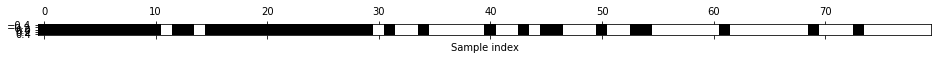

In [11]:
mask = select.get_support()
#visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("Sample index")

In [14]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(solver='liblinear').fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


## Iterative Feature Selection
- in iterative feature selection, we use a series of models with varying numbers of features
- two basic methods:
1. starting with no features and adding features one by one until some stopping crtierion is reached
2. removing features one by one until some stopping criterion is reached
- much more computationally expensive than the methods above
- a particular method is *recursive feature elimination* **(RFE)**
    -  starts with all features
    - builds a model
    - discards the least important feature according to the model
    - then a new model is build using all but the discard feature
    - performed until the prespecfied number of features are left
- requires the model needs to be able to determine feature importance just as in the model-based selection approach



Text(0.5, 0, 'Sample index')

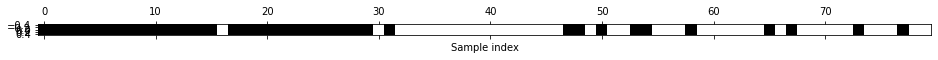

In [15]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel("Sample index")


In [17]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(solver='liblinear').fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3}".format(score))

Test score: 0.951


In [19]:
# performance of the random forest used inside the RFE is the same as that achieved by the training of the logistic regression model using the select features
print("Test score: {:.3}".format(select.score(X_test, y_test)))
# once we've selected the right features, the linear model performs as well as the random forest

Test score: 0.951
